In [5]:
import pandas as pd
import numpy as np



In [ ]:
net = pd.read_csv("./Datasets/combine.csv")

In [7]:
net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             object 
 1    Flow Duration                float64
 2    Total Fwd Packets            float64
 3    Total Backward Packets       float64
 4   Total Length of Fwd Packets   float64
 5    Total Length of Bwd Packets  float64
 6    Fwd Packet Length Max        float64
 7    Fwd Packet Length Min        float64
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         float64
 11   Bwd Packet Length Min        float64
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [8]:
net[" Label"].value_counts(normalize=True) * 100

 Label
BENIGN              75.541259
DoS Hulk            10.434696
PortScan             7.176893
DDoS                 5.781389
DoS GoldenEye        0.464807
DoS slowloris        0.261733
DoS Slowhttptest     0.248321
Bot                  0.088780
Infiltration         0.001626
Heartbleed           0.000497
Name: proportion, dtype: float64

As we can see the data is incredibly unbalanced so the accuracy result will be superficial. We will use models that can handle unbalanced data but we will also oversample the classes below 1%.

Since we are mainly using tree based models no need to perform feature reduction as the models we use handle redundancy pretty well. The only linear model we are using will be used within a voting classifier. The logistic regression and we will apply regularization so the model can perform it internally.

In [9]:
net.duplicated().sum()

np.int64(271280)

In [12]:
net.drop_duplicates(inplace=True)

In [13]:
net.dropna(subset=" Label",inplace= True)

# We drop duplicates and drop all intances of where the Label is null

In [12]:
net[" Label"].value_counts()

 Label
BENIGN              1528605
DoS Hulk             172849
DDoS                 128016
PortScan              90819
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Bot                    1953
Infiltration             36
Heartbleed               11
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
net.select_dtypes(include='number').boxplot(figsize=(12,6))
plt.show()

Since this is a network intrustion Detection system we will leave the outliers be as large numbers can acctually be indicators of attacks.

In [14]:
# the only object other than the target is destination port. Let's change it to an int
net[" Destination Port"] = net[" Destination Port"].astype("float32")
# also lets change all other numeric data types to float 32 to save memory
num_columns = net.select_dtypes(include="number").columns
net[num_columns] = net[num_columns].apply(pd.to_numeric, downcast='float')  # downcast floats


In [15]:
net.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1943188 entries, 0 to 2214467
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             float32
 1    Flow Duration                float64
 2    Total Fwd Packets            float32
 3    Total Backward Packets       float32
 4   Total Length of Fwd Packets   float32
 5    Total Length of Bwd Packets  float64
 6    Fwd Packet Length Max        float32
 7    Fwd Packet Length Min        float32
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         float32
 11   Bwd Packet Length Min        float32
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max              

In [15]:
from sklearn.model_selection import train_test_split
X = net.drop(" Label", axis=1)
y = net[" Label"]

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y, random_state=42)

In [17]:
# we now encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(y_train)
le.transform(y_test)

array([0, 0, 0, ..., 4, 0, 0], shape=(582957,))

In [8]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ReplaceInf(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # store column names if X is DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.to_numpy()
        else:
            self.feature_names_in_ = np.array([f"feature_{i}" for i in range(X.shape[1])])
        return self

    def transform(self, X):
        X_copy = X.copy()
        if isinstance(X_copy, pd.DataFrame):
            X_copy = X_copy.astype(float)
            X_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
        else:
            X_copy = np.array(X_copy, dtype=float)
            X_copy[np.isinf(X_copy)] = np.nan
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_


In [9]:
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer



num_pipeline = make_pipeline(
    ReplaceInf(),
    SimpleImputer(strategy="median"),
)

preprocessing = ColumnTransformer([
("num", num_pipeline,make_column_selector(dtype_include= "number") )

])



In [18]:
processed_X_train = preprocessing.fit_transform(X_train)

In [19]:
preprocessing.get_feature_names_out()

array(['num__ Destination Port', 'num__ Flow Duration',
       'num__ Total Fwd Packets', 'num__ Total Backward Packets',
       'num__Total Length of Fwd Packets',
       'num__ Total Length of Bwd Packets', 'num__ Fwd Packet Length Max',
       'num__ Fwd Packet Length Min', 'num__ Fwd Packet Length Mean',
       'num__ Fwd Packet Length Std', 'num__Bwd Packet Length Max',
       'num__ Bwd Packet Length Min', 'num__ Bwd Packet Length Mean',
       'num__ Bwd Packet Length Std', 'num__Flow Bytes/s',
       'num__ Flow Packets/s', 'num__ Flow IAT Mean',
       'num__ Flow IAT Std', 'num__ Flow IAT Max', 'num__ Flow IAT Min',
       'num__Fwd IAT Total', 'num__ Fwd IAT Mean', 'num__ Fwd IAT Std',
       'num__ Fwd IAT Max', 'num__ Fwd IAT Min', 'num__Bwd IAT Total',
       'num__ Bwd IAT Mean', 'num__ Bwd IAT Std', 'num__ Bwd IAT Max',
       'num__ Bwd IAT Min', 'num__Fwd PSH Flags', 'num__ Bwd PSH Flags',
       'num__ Fwd URG Flags', 'num__ Bwd URG Flags',
       'num__ Fwd Header L

We will now need to deal with how unbalanced the data is by using a mixture of undersampling and oversampling.

In [43]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline
Benign= 500000
sampling_pipeline = imb_Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy={'BENIGN': Benign}, random_state=42)),
    ('oversample', RandomOverSampler(sampling_strategy={
        'Heartbleed': int(0.01 * Benign),
        'Infiltration': int(0.02 * Benign),
        'Bot': int(0.05 * Benign),
       'DoS GoldenEye' :int(0.1 * Benign) ,
        'DoS slowloris' : int(0.07 * Benign ),       
        'DoS Slowhttptest' : int(0.07 * Benign) 
    }, random_state=42))
]) 
# this pipeline will help but is still obviously not balanced however we will let our models do the rest.

Now let's try some models. We will use Tree based models as they handle imbalance very well and are very powerful. 

We start with a simple Decistion tree for simplicity and interpretability. This will help us figure out the most important features and will serve as a baseline for our interprataion of our more complex models using shap

Then we will try a
LGBboost : very fast and powerful, also handles large datasets well


We will not use any Stacking or Voting Classifiers because it would not increase performance enough to justify the complexity, the loss of interprataility and speed loss.
Plus for a real time detection system it is prefferable to prioritize speed and interpretability.




In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
DecisionTreePipeline = imb_Pipeline(
[    ("preprocessing",preprocessing),
     *sampling_pipeline.steps, 
    ("decision_tree",DecisionTreeClassifier(max_depth=5,class_weight="balanced",random_state=42))
 ]
)

In [ ]:
DecisionTreePipeline.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


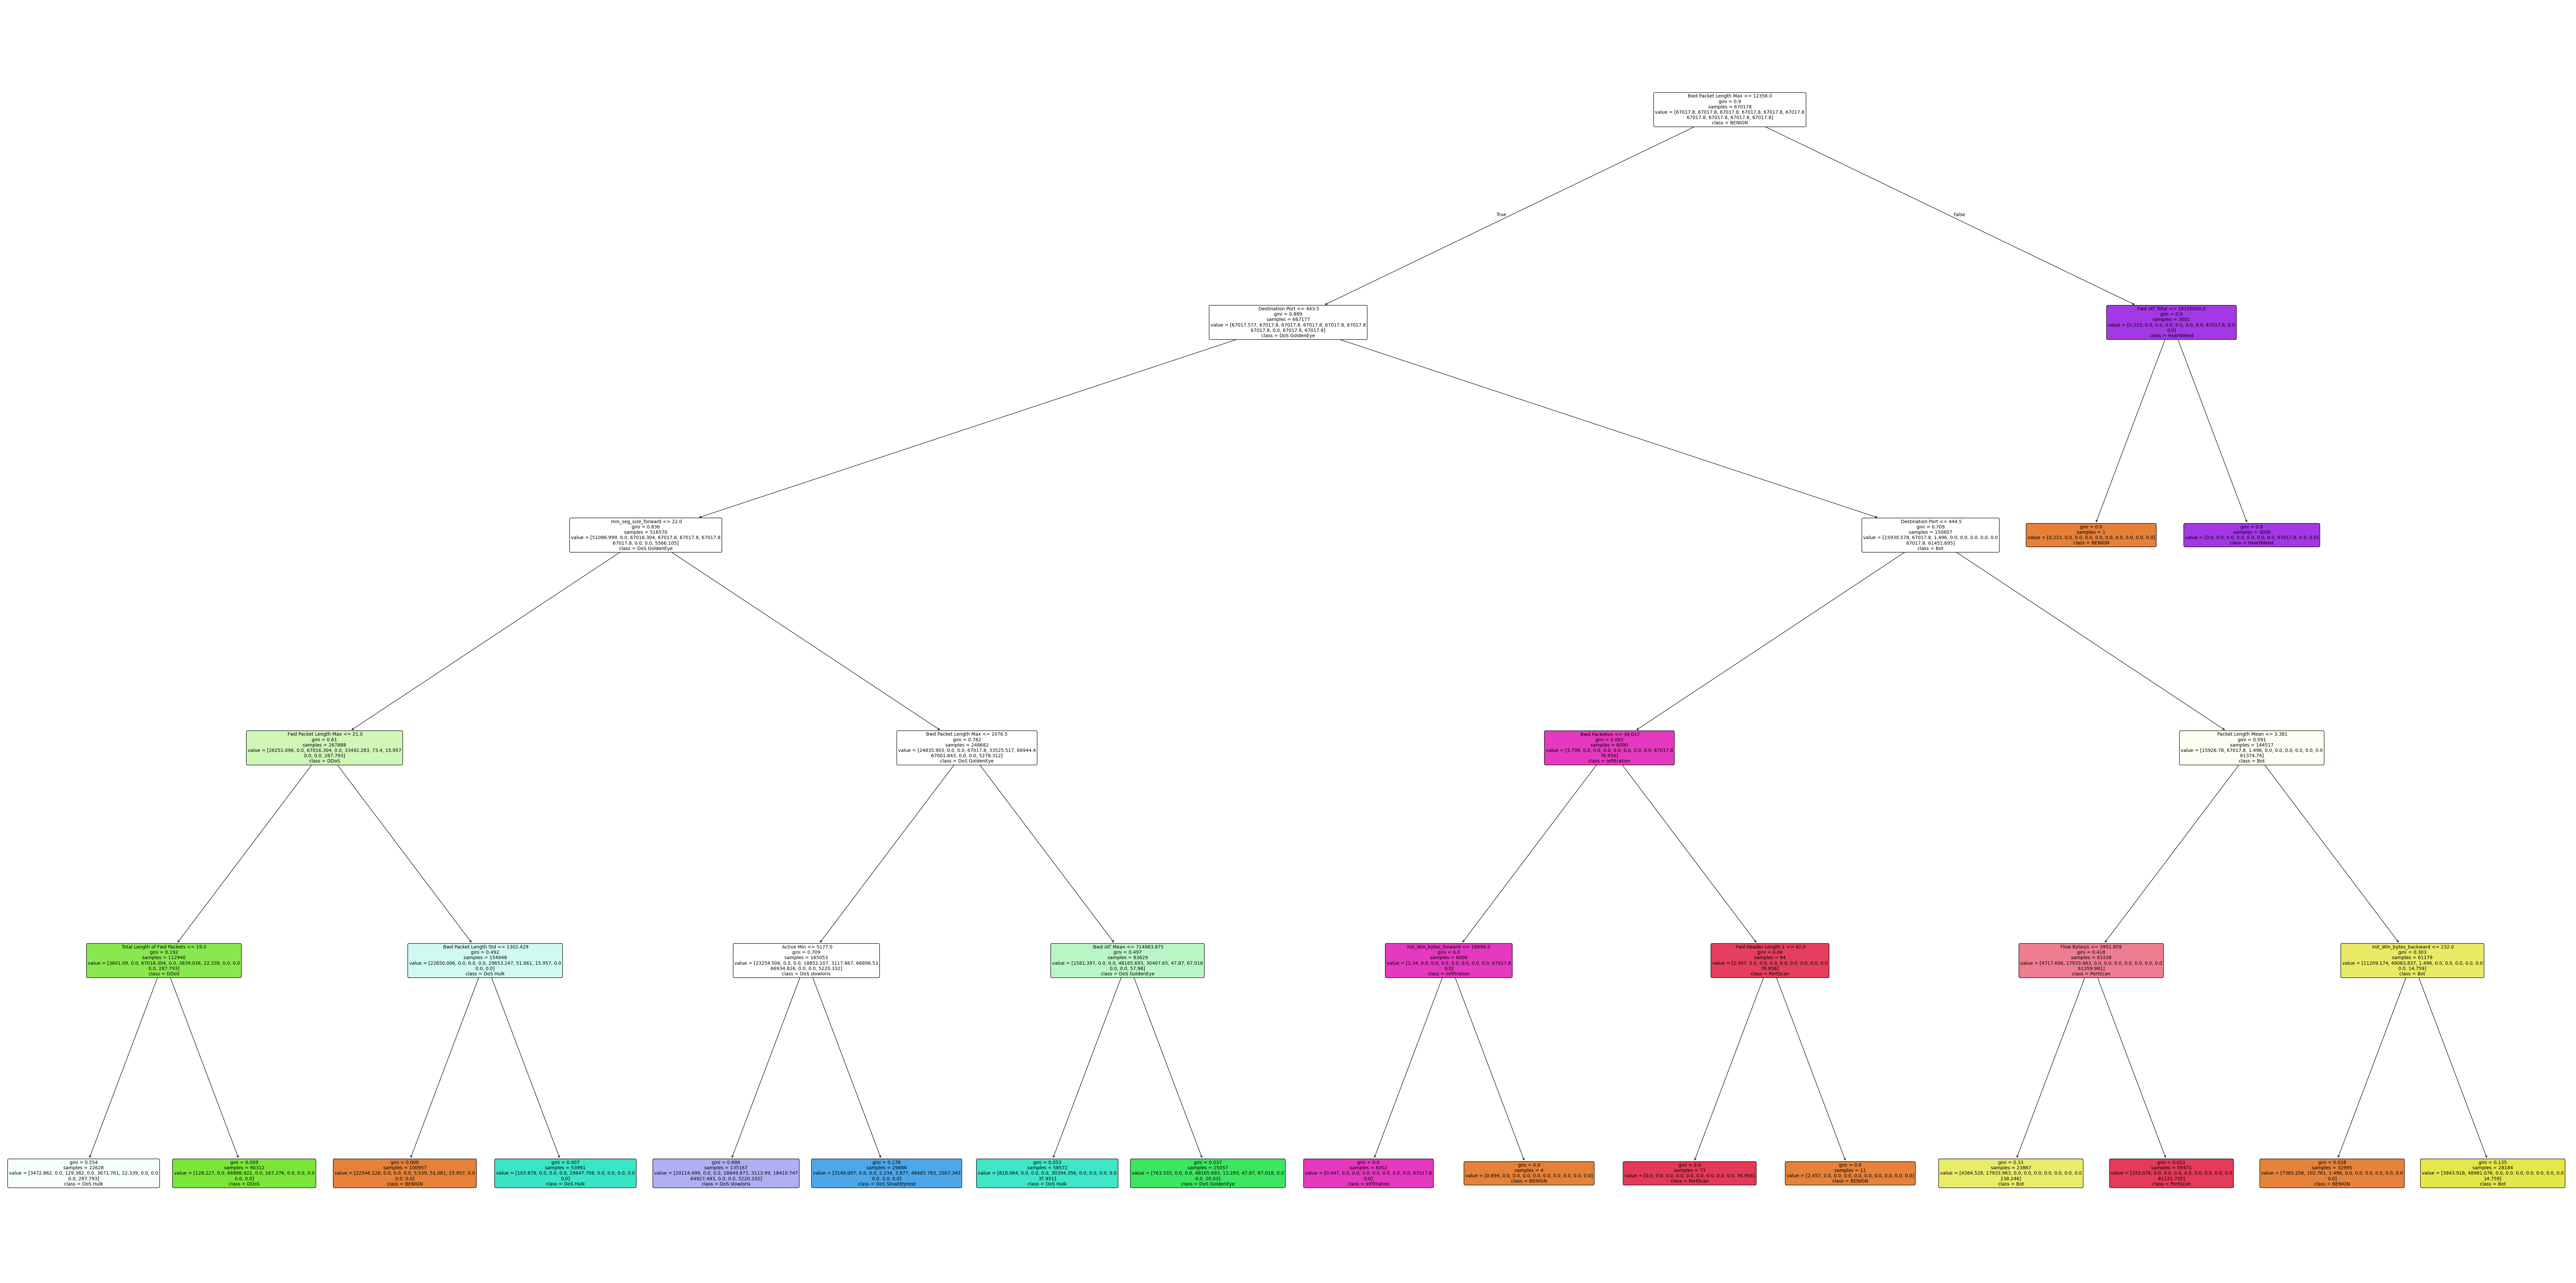

In [ ]:
plt.figure(figsize=(100,50))
tree = DecisionTreePipeline.named_steps["decision_tree"]
plot_tree(tree, 
          feature_names=X_train.columns, 
          class_names=tree.classes_.astype(str),
          filled=True, rounded=True, fontsize=10)
plt.show()

Very tiny but after downloading the image and zooming into the nodes this is what I get from the tree:

Root split separates attacks from normal traffic using features like Flow Duration or Flow Packets/s — short, high-rate flows typically indicate attacks.

DoS and DDoS attacks are characterized by:

Extremely high packet rates and short durations

Frequent SYN/ACK flag activity

Distinctly pure decision nodes (strongly classified)

PortScan traffic shows:

Moderate packet rate

Short connection durations

High variation in inter-arrival times (IAT)

Slow attacks (Slowloris, Slowhttptest) are detected by:

Long flow durations

High idle time and low activity

Patterns opposite to high-speed DoS attacks

Benign flows are recognized by:

Balanced forward/backward packet sizes

Stable timing and packet variance

Low counts of TCP control flags (SYN, ACK, URG, etc.)

Rare classes (Infiltration, Heartbleed) are isolated at the lowest levels:

Identified by irregular packet length and header statistics

Model confidence is lower due to very few samples

Most influential feature families:

Flow timing and duration (Flow Duration, Flow IAT Mean, Idle Mean)

Packet rate and size metrics (Flow Packets/s, Avg Packet Size)

TCP flag counts (SYN, ACK, PSH flags)

Color purity of leaf nodes indicates the model separates attacks well, but minority classes may suffer from overfitting due to data imbalance.

High-level takeaway:
The tree effectively learns to distinguish normal vs. attack behavior through flow timing and packet dynamics, but ensemble methods (e.g., BalancedRandomForest, XGBoost) would yield more balanced generalization across rare attack types.

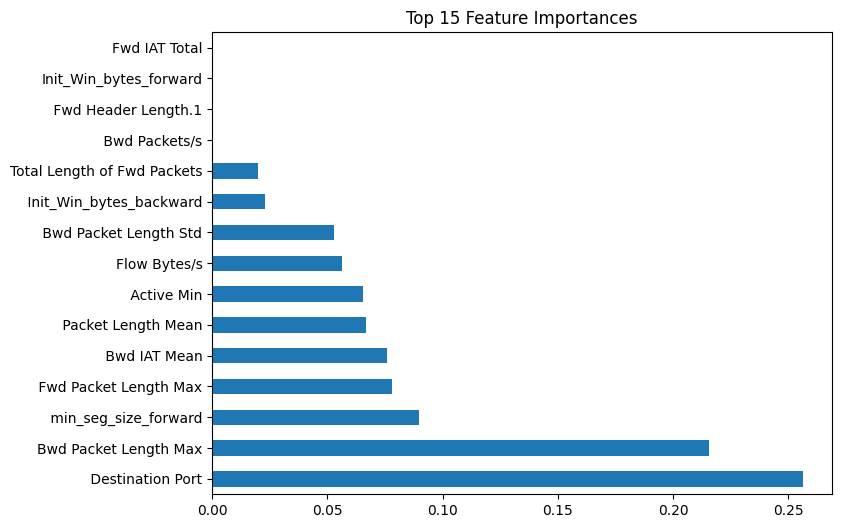

In [ ]:

importances = pd.Series(tree.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
importances.head(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Feature Importances")
plt.show()

In [ ]:
from sklearn.tree import export_text

rules = export_text(tree, feature_names=list(X_train.columns))
print(rules)

|--- Bwd Packet Length Max <= 12356.00
|   |---  Destination Port <= 443.50
|   |   |---  min_seg_size_forward <= 22.00
|   |   |   |---  Fwd Packet Length Max <= 21.00
|   |   |   |   |--- Total Length of Fwd Packets <= 19.00
|   |   |   |   |   |--- class: DoS Hulk
|   |   |   |   |--- Total Length of Fwd Packets >  19.00
|   |   |   |   |   |--- class: DDoS
|   |   |   |---  Fwd Packet Length Max >  21.00
|   |   |   |   |---  Bwd Packet Length Std <= 1302.43
|   |   |   |   |   |--- class: BENIGN
|   |   |   |   |---  Bwd Packet Length Std >  1302.43
|   |   |   |   |   |--- class: DoS Hulk
|   |   |---  min_seg_size_forward >  22.00
|   |   |   |--- Bwd Packet Length Max <= 2076.50
|   |   |   |   |---  Active Min <= 5177.00
|   |   |   |   |   |--- class: DoS slowloris
|   |   |   |   |---  Active Min >  5177.00
|   |   |   |   |   |--- class: DoS Slowhttptest
|   |   |   |--- Bwd Packet Length Max >  2076.50
|   |   |   |   |---  Bwd IAT Mean <= 714883.88
|   |   |   |   |   |--

Destination Port and Bwd Packet Length Max dominate classification — together, they drive >45% of total model importance.

The tree mirrors network logic:

Low ports (HTTP/HTTPS) → web attacks (DoS)

High ports → scans or bots

Long IAT and low packet sizes → slow or infiltration-based threats

Timing features (IAT, Active Min) separate slow from fast attack patterns.

Size features (Packet Length, Bytes/s) separate high-volume floods from stealthy intrusions.

Rare classes (Heartbleed, Infiltration) are isolated by extreme IAT and port conditions.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_ = DecisionTreePipeline.predict(X_train)
print(classification_report(y_train, y_pred_, digits=3))



                  precision    recall  f1-score   support

          BENIGN      1.000     0.446     0.617   1070023
             Bot      0.010     0.999     0.020      1367
            DDoS      0.975     0.998     0.986     89611
   DoS GoldenEye      0.300     0.718     0.423      7200
        DoS Hulk      0.620     0.951     0.751    120994
DoS Slowhttptest      0.050     0.725     0.093      3660
   DoS slowloris      0.011     0.967     0.021      3770
      Heartbleed      0.889     1.000     0.941         8
    Infiltration      0.694     1.000     0.820        25
        PortScan      0.910     0.913     0.912     63573

        accuracy                          0.554   1360231
       macro avg      0.546     0.872     0.558   1360231
    weighted avg      0.950     0.554     0.662   1360231



                  precision    recall  f1-score   support

          BENIGN      1.000     0.446     0.617    458582
             Bot      0.010     1.000     0.020       586
            DDoS      0.974     0.998     0.986     38405
   DoS GoldenEye      0.293     0.709     0.414      3086
        DoS Hulk      0.621     0.951     0.751     51855
DoS Slowhttptest      0.050     0.721     0.093      1568
   DoS slowloris      0.011     0.974     0.021      1615
      Heartbleed      0.750     1.000     0.857         3
    Infiltration      0.909     0.909     0.909        11
        PortScan      0.909     0.913     0.911     27246

        accuracy                          0.554    582957
       macro avg      0.553     0.862     0.558    582957
    weighted avg      0.950     0.554     0.662    582957



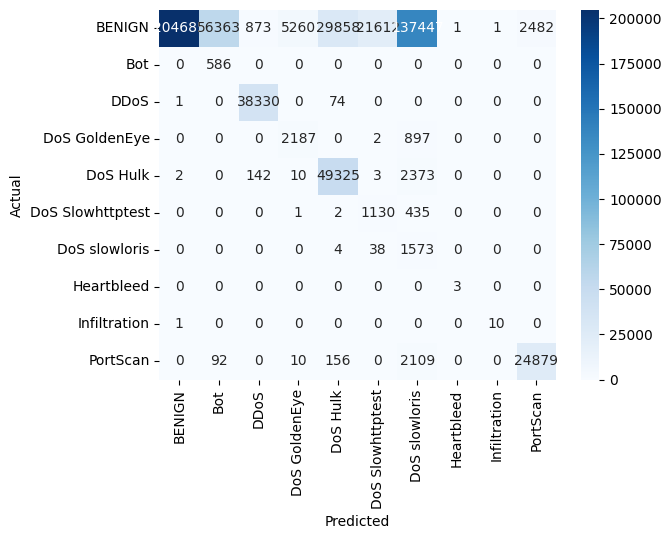

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = DecisionTreePipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=DecisionTreePipeline.classes_, yticklabels=DecisionTreePipeline.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model seems to be underfitting as a whole but doing surprisingly well on some of the classes. This Underfitting is expected for the dcision tree and we will now move on to some ensemble models that we will fine tune. The goal is to get these models to properly separate The benign and attacks extremely well and it's fine if there are some innacuracies within the attacks.

After maximizing the two following models for our goals we will then use shap on both in order to get more insights on what causes certain classifications and gain a stringer understanding of indicators of attacks.

In [44]:
from lightgbm import LGBMClassifier

LGBM_Pipeline = imb_Pipeline(
[    ("preprocessing",preprocessing),
     *sampling_pipeline.steps, 
    ("lgbm",LGBMClassifier( 
    n_estimators=200,
    learning_rate=0.1,
    max_bin = 128,
    max_depth=8,
    is_unbalance=True,
    
    random_state=42))
 ]
)

We will not use the usual Cross validation as it's very hard to use with extremely imbalanced data sets like the one we are using. For the Light GBM we will use monte carlo form of validation using a bunch of randomized test sets while also avoiding stratified sampling as it was getting super messy and complicated when used with over and undersampling

In [60]:
y_train

844642       BENIGN
597946       BENIGN
1816838    DoS Hulk
1050102      BENIGN
69226        BENIGN
             ...   
132870         DDoS
327697     PortScan
239782       BENIGN
1630519    DoS Hulk
70706        BENIGN
Name:  Label, Length: 1360231, dtype: object

In [61]:
X_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
844642,443.0,7643399.0,13.0,13.0,837.0,6649.0,290.0,0.0,64.384613,89.546577,...,12.0,20.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
597946,43832.0,321.0,2.0,0.0,12.0,0.0,6.0,6.0,6.000000,0.000000,...,1.0,20.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1816838,80.0,998.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,32.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1050102,53.0,31011.0,4.0,4.0,168.0,408.0,42.0,42.0,42.000000,0.000000,...,3.0,20.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
69226,80.0,426398.0,3.0,4.0,579.0,925.0,579.0,0.0,193.000000,334.285797,...,1.0,32.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132870,80.0,897804.0,3.0,6.0,26.0,11601.0,20.0,0.0,8.666667,10.263203,...,2.0,20.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
327697,5850.0,46.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,...,0.0,24.0,0.000000e+00,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
239782,443.0,115603080.0,21.0,19.0,1038.0,5084.0,655.0,0.0,49.428570,148.496323,...,4.0,32.0,6.015518e+04,33807.46875,162088.0,49798.0,10000000.0,12434.806641,10000000.0,9994125.0
1630519,80.0,84927296.0,8.0,7.0,347.0,11595.0,341.0,0.0,43.375000,120.276985,...,2.0,20.0,6.313000e+03,0.00000,6313.0,6313.0,84800000.0,0.000000,84800000.0,84800000.0


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

n_runs = 1
scores = []

for i in range(n_runs):
    # New random split each time
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=i * 10
    )

    LGBM_Pipeline.fit(X_tr, y_tr)
    preds = LGBM_Pipeline.predict(X_te)

    f1 = f1_score(y_te, preds, average='macro')
    scores.append(f1)
    print(f"Run {i+1}: Macro-F1 = {f1:.3f}")

print(f"\nMean Macro-F1: {np.mean(scores):.3f}")
print(f"Std deviation: {np.std(scores):.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7237
[LightGBM] [Info] Number of data points in the train set: 879342, number of used features: 70
[LightGBM] [Info] Start training from score -0.564566
[LightGBM] [Info] Start training from score -3.560298
[LightGBM] [Info] Start training from score -2.506837
[LightGBM] [Info] Start training from score -2.867151
[LightGBM] [Info] Start training from score -2.206579
[LightGBM] [Info] Start training from score -3.223826
[LightGBM] [Info] Start training from score -3.223826
[LightGBM] [Info] Start training from score -5.169736
[LightGBM] [Info] Start training from score -4.476589
[LightGBM] [Info] Start training from score -2.850136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Run 1: Macro-F1 = 0.915

Mean Macro-F1: 0.915
Std deviation: 0.000


In [67]:
y_train.value_counts()

 Label
BENIGN              1070023
DoS Hulk             120994
DDoS                  89611
PortScan              63573
DoS GoldenEye          7200
DoS slowloris          3770
DoS Slowhttptest       3660
Bot                    1367
Infiltration             25
Heartbleed                8
Name: count, dtype: int64

In [145]:
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid,ParameterSampler
# helper function for manual automated hyperparameter tuning 
def tune_with_split(pipeline, X, y, param_grid, n_runs=3, test_size=0.2):
    results = []
    
    for params in ParameterSampler(param_grid,n_iter=4):
        run_scores = []
        for seed in range(n_runs):
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, test_size=test_size, stratify=y, random_state=seed * 42
            )

            pipeline.set_params(**params)
            pipeline.fit(X_tr, y_tr)
            preds = pipeline.predict(X_te)

            score = f1_score(y_te, preds, average='macro')
            run_scores.append(score)

        mean_score = np.mean(run_scores)
        std_score = np.std(run_scores)
        results.append((params, mean_score, std_score))

   
    best_params, best_mean, best_std = max(results, key=lambda x: x[1])
    print(f"\n Best params: {best_params}")
    print(f"Mean F1: {best_mean:.4f} ± {best_std:.4f}")

    return results


In [ ]:
from scipy.stats import randint,uniform                                                                 
param_grid = {
    'lgbm__n_estimators': randint(200, 800),         
    'lgbm__max_depth': randint(4, 14),              
    'lgbm__learning_rate': uniform(0.01, 0.15),      
}
results =tune_with_split(LGBM_Pipeline,X_train,y_train,param_grid=param_grid,n_runs=3,test_size=0.2)

In [78]:
df = pd.DataFrame([
    {
        'learning_rate': r[0]['lgbm__learning_rate'],
        'max_depth': r[0]['lgbm__max_depth'],
        'n_estimators': r[0]['lgbm__n_estimators'],
        'mean_f1': r[1],
        'std_f1': r[2],
        'range_min': r[1] - r[2],
        'range_max': r[1] + r[2]
    }
    for r in results
])

# Rank by mean_f1 descending
df = df.sort_values(by='mean_f1', ascending=False).reset_index(drop=True)
df.index += 1  # rank numbering starts at 1

df

,learning_rate,max_depth,n_estimators,mean_f1,std_f1,range_min,range_max
1,0.026207,5,410,0.963572,0.012613,0.950960,0.976185
2,0.033792,4,299,0.962565,0.006006,0.956559,0.968572
3,0.023104,7,456,0.962223,0.010829,0.951394,0.973052
4,0.081914,10,794,0.961414,0.012920,0.948494,0.974335
5,0.024343,6,645,0.959571,0.012976,0.946595,0.972547
6,0.011958,11,396,0.959237,0.012974,0.946263,0.972211
7,0.108153,10,768,0.762225,0.268685,0.493540,1.030910
8,0.092240,8,650,0.761245,0.246913,0.514332,1.008159
9,0.110634,6,540,0.740751,0.298926,0.441826,1.039677
10,0.152840,7,405,0.725993,0.288759,0.437235,1.014752


These results are great, let's now do dome more tuning but within the promising ranges.

In [ ]:
from scipy.stats import randint,uniform                                                                 
param_grid_2 = {
    'lgbm__n_estimators': randint(200, 450),         
    'lgbm__max_depth': randint(4, 6),              
    'lgbm__learning_rate': uniform(0.02, 0.04),      
}
results_2 =tune_with_split(LGBM_Pipeline,X_train,y_train,param_grid=param_grid_2,n_runs=3,test_size=0.2)

In [76]:
df_2 = pd.DataFrame([
    {
        'learning_rate': r[0]['lgbm__learning_rate'],
        'max_depth': r[0]['lgbm__max_depth'],
        'n_estimators': r[0]['lgbm__n_estimators'],
        'mean_f1': r[1],
        'std_f1': r[2],
        'range_min': r[1] - r[2],
        'range_max': r[1] + r[2]
    }
    for r in results_2
])

# Rank by mean_f1 descending
df_2 = df_2.sort_values(by='mean_f1', ascending=False).reset_index(drop=True)
df_2.index += 1  # rank numbering starts at 1

df_2

,learning_rate,max_depth,n_estimators,mean_f1,std_f1,range_min,range_max
1,0.053037,5,349,0.964295,0.012355,0.951940,0.976650
2,0.040740,5,410,0.964230,0.012828,0.951403,0.977058
3,0.051829,4,337,0.963911,0.012514,0.951397,0.976425
4,0.031783,5,370,0.963874,0.012539,0.951335,0.976413
5,0.053117,4,416,0.963782,0.012723,0.951059,0.976505
6,0.044990,4,422,0.963771,0.012796,0.950976,0.976567
7,0.030200,5,322,0.963406,0.012446,0.950961,0.975852
8,0.043904,5,217,0.963396,0.012439,0.950957,0.975835
9,0.027302,5,293,0.963222,0.012586,0.950636,0.975808
10,0.025659,4,383,0.962382,0.006393,0.955989,0.968776


The models are pretty solid my current two favorite models are:
from the second table 
learning_rate	max_depth	n_estimators	mean_f1			std_f1		range_min	range_max
0.053037			5			349			0.964295		0.012355	0.951940	0.976650
0.033792	        4	        299	        0.962565	    0.006006	0.956559	0.968572

The second one learns slower and steadier but has a lower depth leading to less complex trees and better generalization. It has a much smaller variance as well so its more stable. And it also uses less estimators so the model is faster. 
While the first one is more aggressive and learns faster and provides the highest peak performance while also providing good stability. The max_depth is not too high either. We will try can compare both models and if we need a slight boost in performance for both we will try a ensemble with soft voting for the both of them.

In [106]:
LGBM_Pipeline_1 = imb_Pipeline(
[    ("preprocessing",preprocessing),
     *sampling_pipeline.steps, 
    ("lgbm",LGBMClassifier( 
    n_estimators=349,
    learning_rate=0.053037,
    max_bin = 128,
    max_depth=5,
    is_unbalance=True,
    
    random_state=42))
 ]
)

In [120]:
LGBM_Pipeline_2 = imb_Pipeline(
[    ("preprocessing",preprocessing),
     *sampling_pipeline.steps, 
    ("lgbm",LGBMClassifier( 
    n_estimators=299,
    learning_rate=0.033792,
    max_bin = 128,
    max_depth=4,
    is_unbalance=True,
    
    random_state=42))
 ]
)

In [132]:
# we will now optimize both models on a final validation set

X_tr, X_te, y_tr, y_te = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

LGBM_Pipeline_1.fit(X_tr, y_tr)


LGBM_Pipeline_2.fit(X_tr, y_tr)




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7255
[LightGBM] [Info] Number of data points in the train set: 879342, number of used features: 70
[LightGBM] [Info] Start training from score -0.564566
[LightGBM] [Info] Start training from score -3.560298
[LightGBM] [Info] Start training from score -2.506837
[LightGBM] [Info] Start training from score -2.867151
[LightGBM] [Info] Start training from score -2.206579
[LightGBM] [Info] Start training from score -3.223826
[LightGBM] [Info] Start training from score -3.223826
[LightGBM] [Info] Start training from score -5.169736
[LightGBM] [Info] Start training from score -4.476589
[LightGBM] [Info] Start training from score -2.850136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

,steps,"[('preprocessing', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
preds_1 = LGBM_Pipeline_1.predict(X_te)
preds_2 = LGBM_Pipeline_2.predict(X_te)



In [134]:
# Second models predictions on validation set 
print(classification_report(y_te,preds_2))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    214005
             Bot       0.65      1.00      0.79       273
            DDoS       1.00      1.00      1.00     17922
   DoS GoldenEye       0.99      1.00      0.99      1440
        DoS Hulk       1.00      1.00      1.00     24199
DoS Slowhttptest       1.00      0.99      0.99       732
   DoS slowloris       0.99      1.00      0.99       754
      Heartbleed       1.00      1.00      1.00         2
    Infiltration       0.83      1.00      0.91         5
        PortScan       0.99      1.00      0.99     12715

        accuracy                           1.00    272047
       macro avg       0.95      1.00      0.97    272047
    weighted avg       1.00      1.00      1.00    272047



In [135]:
# first models predictions on validation set
print(classification_report(y_te,preds_1))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    214005
             Bot       0.69      0.99      0.81       273
            DDoS       1.00      1.00      1.00     17922
   DoS GoldenEye       1.00      1.00      1.00      1440
        DoS Hulk       1.00      1.00      1.00     24199
DoS Slowhttptest       0.99      0.99      0.99       732
   DoS slowloris       0.99      1.00      0.99       754
      Heartbleed       1.00      1.00      1.00         2
    Infiltration       1.00      1.00      1.00         5
        PortScan       0.99      1.00      0.99     12715

        accuracy                           1.00    272047
       macro avg       0.97      1.00      0.98    272047
    weighted avg       1.00      1.00      1.00    272047



Model one is scoring higher which is expected as it is slightly more complex

In [136]:
#Checking first model's fit on the training set

fit_preds_1 = LGBM_Pipeline_1.predict(X_tr)
print(classification_report(y_tr,fit_preds_1))

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    856018
             Bot       0.72      1.00      0.84      1094
            DDoS       1.00      1.00      1.00     71689
   DoS GoldenEye       1.00      1.00      1.00      5760
        DoS Hulk       1.00      1.00      1.00     96795
DoS Slowhttptest       1.00      1.00      1.00      2928
   DoS slowloris       1.00      1.00      1.00      3016
      Heartbleed       1.00      1.00      1.00         6
    Infiltration       1.00      1.00      1.00        20
        PortScan       0.99      1.00      0.99     50858

        accuracy                           1.00   1088184
       macro avg       0.97      1.00      0.98   1088184
    weighted avg       1.00      1.00      1.00   1088184



In [137]:
#Checking second model's fit on the training set
fit_preds_2 = LGBM_Pipeline_2.predict(X_tr)
print(classification_report(y_tr,fit_preds_2))

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    856018
             Bot       0.67      1.00      0.80      1094
            DDoS       1.00      1.00      1.00     71689
   DoS GoldenEye       0.99      1.00      1.00      5760
        DoS Hulk       1.00      1.00      1.00     96795
DoS Slowhttptest       0.99      1.00      1.00      2928
   DoS slowloris       0.99      1.00      1.00      3016
      Heartbleed       1.00      1.00      1.00         6
    Infiltration       0.95      1.00      0.98        20
        PortScan       0.99      1.00      0.99     50858

        accuracy                           1.00   1088184
       macro avg       0.96      1.00      0.98   1088184
    weighted avg       1.00      1.00      1.00   1088184



The second model acctually overfits slightly more in this situation maybe it's probably due to it's lower learning rate. The model overfits slightly more. They overfit around the same on Bot but the second model overfits more on the Infiltration and the macro average itself which is the most important score. We can tell that it's underfitting some of the nuances in the data particularily within the smaller classes and also overfits slightly more so we can safely proceed with our first model. 

Finally we will play around with the Bot oversampling just a little and attempt to maximize our first models score.
Let's look at a confusion matrix first so we can geta better understadning of the mistakes

<Figure size 1200x600 with 0 Axes>

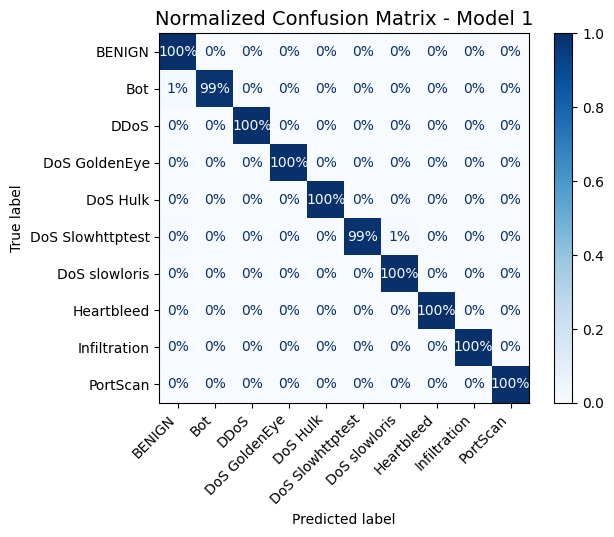

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 6))  # wider figure
ConfusionMatrixDisplay.from_predictions(
    y_te, preds_1,
    normalize="true",
    values_format=".0%",
    cmap="Blues"  # optional: cleaner look
)
plt.title("Normalized Confusion Matrix - Model 1", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()


<Figure size 1200x600 with 0 Axes>

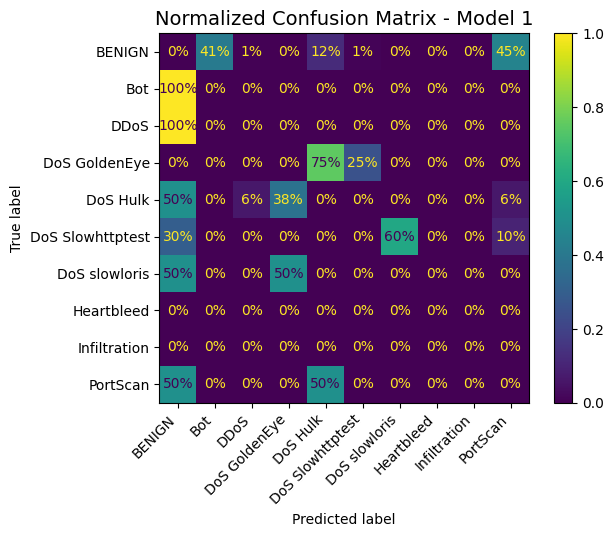

In [144]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 6))  # wider figure
sample_weight = (y_te != preds_1)
ConfusionMatrixDisplay.from_predictions(y_te, preds_1,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")

plt.title("Normalized Confusion Matrix - Model 1", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

These are very promising results, the classification for this validation set is almost perfect with the weaklink being Bpt. Most of the errors just misclassifying as benighn which makes sense due to the imbalance and while there is much we can interpret from this as DOS attacks are usually misclassified as other DOS attack and Port scans as Dos attacks as well these conections make sensebut the onmly error that is significant in this model isthe Bot so let's focus on that.

100% of the Bot misclasifications were classified as benign so this is probably just an imbalance problem and we can improve this by playing around with the bot and over sampling ratio. This will be our final hypertuning as this model is already pretty solid. If we are not satisfied with the results we may try an ensemble with my second model.

In [ ]:
LGBM_Pipeline_1_Bot = imb_Pipeline(
[    ("preprocessing",preprocessing),
 ('undersample', RandomUnderSampler(sampling_strategy={'BENIGN': Benign}, random_state=42)),
    ('oversample', RandomOverSampler(sampling_strategy={
        'Heartbleed': int(0.01 * Benign),
        'Infiltration': int(0.02 * Benign),
        'Bot': int(0.05 * Benign),
       'DoS GoldenEye' :int(0.1 * Benign) ,
        'DoS slowloris' : int(0.07 * Benign ),       
        'DoS Slowhttptest' : int(0.07 * Benign) 
    }, random_state=42))    ("lgbm",LGBMClassifier( 
    n_estimators=349,
    learning_rate=0.053037,
    max_bin = 128,
    max_depth=5,
    is_unbalance=True,
    
    random_state=42))
 ]
)

In [147]:
param_grid_bot = {
    'oversample__sampling_strategy': [
        {
            'Heartbleed': int(0.01 * Benign),
            'Infiltration': int(0.02 * Benign),
            'Bot': int(0.03 * Benign),
            'DoS GoldenEye': int(0.1 * Benign),
            'DoS slowloris': int(0.07 * Benign),
            'DoS Slowhttptest': int(0.07 * Benign)
        },
        {
            'Heartbleed': int(0.01 * Benign),
            'Infiltration': int(0.02 * Benign),
            'Bot': int(0.05 * Benign),
            'DoS GoldenEye': int(0.1 * Benign),
            'DoS slowloris': int(0.07 * Benign),
            'DoS Slowhttptest': int(0.07 * Benign)
        },
        {
            'Heartbleed': int(0.01 * Benign),
            'Infiltration': int(0.02 * Benign),
            'Bot': int(0.07 * Benign),
            'DoS GoldenEye': int(0.1 * Benign),
            'DoS slowloris': int(0.07 * Benign),
            'DoS Slowhttptest': int(0.07 * Benign)
        },
        {
            'Heartbleed': int(0.01 * Benign),
            'Infiltration': int(0.02 * Benign),
            'Bot': int(0.1 * Benign),
            'DoS GoldenEye': int(0.1 * Benign),
            'DoS slowloris': int(0.07 * Benign),
            'DoS Slowhttptest': int(0.07 * Benign)
        },
    ]
}


In [ ]:
results_Bot_tuned =tune_with_split(LGBM_Pipeline_1_Bot,X_train,y_train,param_grid=param_grid_bot,n_runs=3,test_size=0.2)

In [151]:
results_Bot_tuned

[({'oversample__sampling_strategy': {'Heartbleed': 5000,
    'Infiltration': 10000,
    'Bot': 15000,
    'DoS GoldenEye': 50000,
    'DoS slowloris': 35000,
    'DoS Slowhttptest': 35000}},
  np.float64(0.9668823430937094),
  np.float64(0.008515959461795388)),
 ({'oversample__sampling_strategy': {'Heartbleed': 5000,
    'Infiltration': 10000,
    'Bot': 25000,
    'DoS GoldenEye': 50000,
    'DoS slowloris': 35000,
    'DoS Slowhttptest': 35000}},
  np.float64(0.9643841914622148),
  np.float64(0.012774166635377919)),
 ({'oversample__sampling_strategy': {'Heartbleed': 5000,
    'Infiltration': 10000,
    'Bot': 35000,
    'DoS GoldenEye': 50000,
    'DoS slowloris': 35000,
    'DoS Slowhttptest': 35000}},
  np.float64(0.9597699938118787),
  np.float64(0.012706664097198202)),
 ({'oversample__sampling_strategy': {'Heartbleed': 5000,
    'Infiltration': 10000,
    'Bot': 50000,
    'DoS GoldenEye': 50000,
    'DoS slowloris': 35000,
    'DoS Slowhttptest': 35000}},
  np.float64(0.96390379

In [157]:



# Convert to DataFrame
df_3 = pd.DataFrame([{
    'Bot_samples': r[0]['oversample__sampling_strategy']['Bot'],
    'Heartbleed': r[0]['oversample__sampling_strategy']['Heartbleed'],
    'Infiltration': r[0]['oversample__sampling_strategy']['Infiltration'],
    'DoS_GoldenEye': r[0]['oversample__sampling_strategy']['DoS GoldenEye'],
    'DoS_slowloris': r[0]['oversample__sampling_strategy']['DoS slowloris'],
    'DoS_Slowhttptest': r[0]['oversample__sampling_strategy']['DoS Slowhttptest'],
    'Mean_F1': r[1],
    'Std_F1': r[2],
    'F1_min': r[1] - r[2],
    'F1_max': r[1] + r[2]
} for r in results_Bot_tuned])

df_3


,Bot_samples,Heartbleed,Infiltration,DoS_GoldenEye,DoS_slowloris,DoS_Slowhttptest,Mean_F1,Std_F1,F1_min,F1_max
0,15000,5000,10000,50000,35000,35000,0.966882,0.008516,0.958366,0.975398
1,25000,5000,10000,50000,35000,35000,0.964384,0.012774,0.951610,0.977158
2,35000,5000,10000,50000,35000,35000,0.959770,0.012707,0.947063,0.972477
3,50000,5000,10000,50000,35000,35000,0.963904,0.012491,0.951413,0.976395


seems like in the Bot's case some of the over sampling may be casuing some noise and therefore making the performance worse. We will now manually try a bunch of different smaller ratios for the Bot.

In [23]:
from imblearn.pipeline import Pipeline as imb_Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier


In [50]:
Benign = 500000
sampling_pipeline_new = imb_Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy={'BENIGN': Benign}, random_state=42)),
    ('oversample', RandomOverSampler(sampling_strategy={
        'Heartbleed': int(0.01 * Benign),
        'Infiltration': int(0.02 * Benign),
        'Bot': int(0.02 * Benign),
       'DoS GoldenEye' :int(0.1 * Benign) ,
        'DoS slowloris' : int(0.07 * Benign ),       
        'DoS Slowhttptest' : int(0.07 * Benign) 
    }, random_state=42))
]) 

In [51]:
LGBM_Pipeline_2_Bot = imb_Pipeline(
[    ("preprocessing",preprocessing),
 *sampling_pipeline_new.steps,

    ("lgbm",LGBMClassifier( 
    n_estimators=349,
    learning_rate=0.053037,
    max_bin = 128,
    max_depth=5,
    is_unbalance=True,
    
    random_state=42))
 ]
)

In [ ]:

X_tr, X_te, y_tr, y_te = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

LGBM_Pipeline_2_Bot.fit(X_tr, y_tr)

In [53]:
preds_Bot_2 = LGBM_Pipeline_2_Bot.predict(X_te)

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [54]:
print(classification_report(y_te,preds_Bot_2))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    214005
             Bot       0.69      0.99      0.81       273
            DDoS       1.00      1.00      1.00     17922
   DoS GoldenEye       0.99      1.00      0.99      1440
        DoS Hulk       1.00      1.00      1.00     24199
DoS Slowhttptest       0.99      0.98      0.99       732
   DoS slowloris       0.99      1.00      0.99       754
      Heartbleed       1.00      1.00      1.00         2
    Infiltration       1.00      1.00      1.00         5
        PortScan       0.99      1.00      0.99     12715

        accuracy                           1.00    272047
       macro avg       0.97      1.00      0.98    272047
    weighted avg       1.00      1.00      1.00    272047



After trying many ratios smaller than 0.02 the best results were consistently from using a ratio of 0.02. At 0.01 we reached the highest precision 0.71 but we it dropped recall the 96% and in this case we need to optimize for recall because we want to catch as many attacks as possible and there are so many benign cases that a 69% precision for one class is a very small problem.
We will now try my first and second best model using a voting classifier and see if any improvement on Bot's precision can be made.

In [55]:

LGBM_Pipeline_3_Bot = imb_Pipeline(
[    ("preprocessing",preprocessing),
     *sampling_pipeline_new.steps, 
    ("lgbm",LGBMClassifier( 
    n_estimators=299,
    learning_rate=0.033792,
    max_bin = 128,
    max_depth=4,
    is_unbalance=True,
    
    random_state=42))
 ]
)

In [ ]:
# first let's look at how my second model performs with this new change in ratio
LGBM_Pipeline_3_Bot.fit(X_tr,y_tr)

In [ ]:
preds_Bot_3 = LGBM_Pipeline_3_Bot.predict(X_te)

In [58]:
print(classification_report(y_te,preds_Bot_3))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    214005
             Bot       0.66      0.99      0.79       273
            DDoS       1.00      1.00      1.00     17922
   DoS GoldenEye       0.99      1.00      0.99      1440
        DoS Hulk       1.00      1.00      1.00     24199
DoS Slowhttptest       0.99      0.98      0.99       732
   DoS slowloris       0.99      1.00      0.99       754
      Heartbleed       1.00      1.00      1.00         2
    Infiltration       0.83      1.00      0.91         5
        PortScan       0.99      1.00      0.99     12715

        accuracy                           1.00    272047
       macro avg       0.94      1.00      0.97    272047
    weighted avg       1.00      1.00      1.00    272047



Good performance on both models, we can now try an ensemble and see how it fairs.

In [ ]:
pred_1_ = LGBM_Pipeline_2_Bot.predict_proba(X_te)
pred_2_ = LGBM_Pipeline_3_Bot.predict_proba(X_te)
ensemble = (pred_1_ + pred_2_)/2

In [60]:
ensemble_preds = np.argmax(ensemble,axis=1)
class_labels = LGBM_Pipeline_2_Bot.classes_

ensemble_preds_str = [class_labels[i] for i in ensemble_preds]


print(classification_report(y_te,ensemble_preds_str))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    214005
             Bot       0.68      0.99      0.80       273
            DDoS       1.00      1.00      1.00     17922
   DoS GoldenEye       0.99      1.00      0.99      1440
        DoS Hulk       1.00      1.00      1.00     24199
DoS Slowhttptest       0.99      0.99      0.99       732
   DoS slowloris       0.99      1.00      0.99       754
      Heartbleed       1.00      1.00      1.00         2
    Infiltration       1.00      1.00      1.00         5
        PortScan       0.99      1.00      0.99     12715

        accuracy                           1.00    272047
       macro avg       0.96      1.00      0.98    272047
    weighted avg       1.00      1.00      1.00    272047



Not enough improvement to justify using as ensemble, it's almost Identical to my best model. We can go ahead and test our best model on the test set and see how it fairs. First we will test it on the training set so we can evaluate how much our model overfits as well.

In [ ]:
LGBM_Pipeline_2_Bot.fit(X_train,y_train)

In [62]:
Final_fit_preds = LGBM_Pipeline_2_Bot.predict(X_train)

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [63]:
print(classification_report(y_train,Final_fit_preds))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00   1070023
             Bot       0.71      1.00      0.83      1367
            DDoS       1.00      1.00      1.00     89611
   DoS GoldenEye       1.00      1.00      1.00      7200
        DoS Hulk       1.00      1.00      1.00    120994
DoS Slowhttptest       1.00      1.00      1.00      3660
   DoS slowloris       1.00      1.00      1.00      3770
      Heartbleed       1.00      1.00      1.00         8
    Infiltration       1.00      1.00      1.00        25
        PortScan       0.99      1.00      0.99     63573

        accuracy                           1.00   1360231
       macro avg       0.97      1.00      0.98   1360231
    weighted avg       1.00      1.00      1.00   1360231



In [64]:
Final_preds = LGBM_Pipeline_2_Bot.predict(X_test)

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [65]:
print(classification_report(y_test,Final_preds))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    458582
             Bot       0.70      0.99      0.82       586
            DDoS       1.00      1.00      1.00     38405
   DoS GoldenEye       0.99      1.00      1.00      3086
        DoS Hulk       1.00      1.00      1.00     51855
DoS Slowhttptest       0.99      0.99      0.99      1568
   DoS slowloris       0.99      1.00      0.99      1615
      Heartbleed       1.00      1.00      1.00         3
    Infiltration       1.00      1.00      1.00        11
        PortScan       0.99      1.00      0.99     27246

        accuracy                           1.00    582957
       macro avg       0.97      1.00      0.98    582957
    weighted avg       1.00      1.00      1.00    582957



The generalization error is great, some of the precisions and recalls got a slight boost probably because it had access to more instances of the specific class for training therefore Oversampling was less aggresive. The model barely overfits on the Bot, DOS slowloris and Dos Slowhttptest and it's only by one percentage point while all the other classes are identical and the macro average remains the same. Overall the model is very strong and generalizes well let's save it.

Possible future implementations:
Hyper tune all of the oversampling rather than just the weakest link: 
unlikely to improve accuracy considering how well it takes care of those classes
But it will increase efficiency though if we can find the lowest possible amount of oversampling that keep the current models performance. This will lead to better faster training and predictions. It may also decrease the slight overfitting on DOS slowloris and Dos Slowhttptest.

Use an ensemble with a very different model:
This may improve performance but will significantly decrease interpretability and efficiency so this is an unlikely change. LGBM is already a powerful ensemble and the Voting classifier that was used did not increase performance, however it was using two very similar models so it makes sense



In [67]:
import joblib
joblib.dump(LGBM_Pipeline_2_Bot,"NetworkIntrusionDetection")

['NetworkIntrusionDetection']

In [72]:
import shap
final_tree = LGBM_Pipeline_2_Bot.named_steps["lgbm"]
explainer = shap.TreeExplainer(final_tree,feature_perturbation="tree_path_dependent")

In [82]:
X_transformed = preprocessing.transform(X_test)

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = X_transformed.copy()
df = pd.DataFrame(df,columns=X_test.columns)
df['Label'] = y_test.values

rare_threshold = 30       
stratify_frac = 0.02       
random_state = 42

# --- Separate rare and common classes ---
rare_df = df[df.groupby('Label')['Label'].transform('count') <= rare_threshold]
common_df = df[~df.index.isin(rare_df.index)]

# --- Stratified sampling on common classes (2%) ---
X_common = common_df.drop(columns=['Label'])
y_common = common_df['Label']

X_common_sample, _, y_common_sample, _ = train_test_split(
    X_common, y_common,
    stratify=y_common,
    test_size=(1- stratify_frac),  # keep 2% of common data
    random_state=random_state
)

# --- Combine everything back ---
X_subset = pd.concat([X_common_sample, rare_df.drop(columns=['Label'])], ignore_index=True)
y_subset = pd.concat([y_common_sample, rare_df['Label']], ignore_index=True)




In [98]:
shap_values = explainer.shap_values(X_subset)

In [114]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("Num classes:", len(shap_values))
    print("Shape of each:", [sv.shape for sv in shap_values])
else:
    print("Shape:", shap_values.shape)

<class 'numpy.ndarray'>
Shape: (11672, 78, 10)


In [117]:
import numpy as np
import pandas as pd

# shap_values shape = (n_samples, n_features, n_classes)
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2))  # average over samples & classes

importance_df = pd.DataFrame({
    "feature": X_test.columns,  # use X_test.columns or pipeline.get_feature_names_out()
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)


In [120]:
print(importance_df.head(20))


                         feature  mean_abs_shap
0               Destination Port       0.979433
66        Init_Win_bytes_forward       0.545048
69          min_seg_size_forward       0.452886
67       Init_Win_bytes_backward       0.263116
37                 Bwd Packets/s       0.247151
34             Fwd Header Length       0.208287
12        Bwd Packet Length Mean       0.193029
19                  Flow IAT Min       0.158435
13         Bwd Packet Length Std       0.156547
22                   Fwd IAT Std       0.153075
40            Packet Length Mean       0.141864
1                  Flow Duration       0.135699
24                   Fwd IAT Min       0.134214
23                   Fwd IAT Max       0.132884
21                  Fwd IAT Mean       0.127832
5    Total Length of Bwd Packets       0.126003
6          Fwd Packet Length Max       0.122342
52           Average Packet Size       0.113628
68              act_data_pkt_fwd       0.113504
14                  Flow Bytes/s       0

Interpretation 
The SHAP  analysis reveals that the model’s decisions are primarily driven by network-flow characteristics that reflect protocol behavior and traffic dynamics, not random statistical noise.
Across all attack categories, the most influential features are:

Destination Port – the strongest global indicator; different attacks consistently target specific or abnormal ports (e.g., web-service DoS on port 80, SSL Heartbleed on 443).

TCP window-based features such as Init_Win_bytes_forward and Init_Win_bytes_backward, which capture abnormal handshake or flow-control behavior.

Segment-size and packet-rate features (min_seg_size_forward, Bwd Packets/s, Fwd Header Length) describing how aggressively data is fragmented or transmitted.

Timing features (Flow IAT Min, Fwd IAT Std) measuring the burstiness and irregularity of traffic.

Packet-length statistics (Bwd Packet Length Mean/Std, Average Packet Size) reflecting payload size consistency.

Let's move on to per class analysis which will give us an even better understanding

In [122]:
# shape: (n_features, n_classes)
mean_abs_per_class = np.abs(shap_values).mean(axis=0)

# make a DataFrame to inspect top features per class
importance_per_class = pd.DataFrame(mean_abs_per_class, index=X_test.columns)
importance_per_class.columns = final_tree.classes_.astype(str) # if available


In [136]:
top_features_per_class = {}

for col in importance_per_class.columns:
    top_features_per_class[col] = (
        importance_per_class[col]
        .sort_values(ascending=False)
        .head(20)
    )


In [137]:

top_features_df = pd.concat(
    {cls: importance_per_class[col].sort_values(ascending=False).head(20)
     for cls, col in enumerate(importance_per_class.columns)},
    axis=1
)

top_features_df.columns = importance_per_class.columns  # use class names as headers
top_features_df


,BENIGN,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,Heartbleed,Infiltration,PortScan
Init_Win_bytes_forward,1.329413,0.380877,0.764371,0.615623,1.288714,NaN,0.303678,NaN,0.264503,0.411975
Destination Port,1.146459,0.635119,0.823633,1.378459,1.446043,2.129293,1.601055,0.022316,0.299548,0.312409
Init_Win_bytes_backward,1.057739,0.135958,0.615923,0.260660,0.246213,0.160784,NaN,NaN,0.030100,NaN
Bwd Packet Length Std,1.042330,0.040914,NaN,NaN,NaN,NaN,NaN,0.046508,NaN,NaN
Bwd Packet Length Mean,0.838780,NaN,NaN,0.097942,0.219175,NaN,0.351587,0.106698,NaN,0.173599
Total Length of Bwd Packets,0.333097,NaN,0.259930,0.205500,0.242976,NaN,0.139151,0.022611,NaN,NaN
Fwd Header Length,0.266983,NaN,NaN,NaN,1.066981,NaN,NaN,0.043581,0.092329,0.327932
min_seg_size_forward,0.158570,NaN,0.471376,0.897318,NaN,1.471258,1.129194,NaN,0.242554,NaN
Fwd IAT Min,0.134003,NaN,0.152639,NaN,0.227084,0.137431,0.116853,NaN,0.372517,0.141005
Idle Min,0.126575,NaN,0.135575,0.252378,0.208591,0.102724,NaN,NaN,NaN,NaN


The table has the top 20 features for each class This is the final interpretation

## ⚔️ Per-Class SHAP Interpretations (Top 20 Features Each)

---

### 🟢 BENIGN
**Dominant features:**  
`Init_Win_bytes_forward`, `Destination Port`, `Init_Win_bytes_backward`,  
`Bwd Packet Length Std`, `Bwd Packet Length Mean`, `Total Length of Bwd Packets`

**Interpretation:**  
Benign network flows exhibit **consistent packet sizes**, **balanced window sizes**, and **common ports** (e.g., 80, 443).  
Stable bidirectional patterns and regular inter-arrival times are clear signals of legitimate traffic.  
The model recognizes symmetric TCP window negotiation and low variance in packet size as normal behavior.

---

### 🔴 Bot
**Dominant features:**  
`Destination Port`, `Bwd IAT Std`, `Fwd IAT Std`, `Flow Packets/s`,  
`Down/Up Ratio`, `Flow Bytes/s`

**Interpretation:**  
Bot traffic maintains **periodic communications** with command-and-control servers using **fixed ports**.  
Consistent timing (low variance in IATs) and stable packet-rate ratios (`Down/Up Ratio`) reflect automated communication patterns.  
The model detects this regularity as a hallmark of botnet-controlled flows.

---

### 🔶 DDoS
**Dominant features:**  
`Destination Port`, `Init_Win_bytes_forward`, `ACK Flag Count`,  
`act_data_pkt_fwd`, `Total Length of Fwd Packets`,  
`Fwd Packet Length Std`, `Fwd Packet Length Mean`, `URG Flag Count`

**Interpretation:**  
DDoS flows target **specific ports** with **large numbers of small, rapid requests**.  
Features like `act_data_pkt_fwd` and `ACK/URG Flag Count` capture excessive synchronization and acknowledgment activity typical of volumetric attacks.  
High throughput (`Flow Duration` low, packets frequent) indicates intense network flooding.

---

### 🟠 DoS GoldenEye
**Dominant features:**  
`Destination Port`, `Init_Win_bytes_forward`, `Flow Duration`,  
`Bwd IAT Mean`, `Flow IAT Max`, `Fwd IAT Max`,  
`Fwd IAT Total`, `Idle Min`, `Active Min`

**Interpretation:**  
DoS-GoldenEye sends **massive HTTP request floods** to web ports, with **very short flow durations** and **burst timing**.  
The model picks up abnormal **IAT distributions** and **window size irregularities**, identifying the characteristic signature of sustained application-layer flooding.

---

### 🔵 DoS Hulk
**Dominant features:**  
`Destination Port`, `Init_Win_bytes_forward`, `Fwd Header Length`,  
`Flow IAT Min`, `FIN Flag Count`, `PSH Flag Count`,  
`Flow Bytes/s`, `Bwd Packet Length Min`

**Interpretation:**  
DoS-Hulk uses extremely high request rates on standard web ports.  
The model relies on **port targeting**, **abnormal header lengths**, and **flag activity (FIN, PSH)** to identify the aggressive TCP handshakes typical of Hulk floods.  
Elevated throughput (`Flow Bytes/s`) and erratic packet minima reflect packet-level saturation.

---

### 🟣 DoS Slowhttptest
**Dominant features:**  
`Destination Port`, `min_seg_size_forward`, `Idle Min`,  
`Flow IAT Max`, `Fwd IAT Max`, `Flow Packets/s`,  
`Fwd Packets/s`, `Flow Bytes/s`

**Interpretation:**  
Slowhttptest attacks hold connections open by sending **small segments slowly**,  
resulting in **high idle times** and **low packet throughput**.  
The model captures this through segment size (`min_seg_size_forward`) and timing features (`Idle Min`, `Flow IAT Max`), which highlight artificially prolonged sessions.

---

### 🟣 DoS Slowloris
**Dominant features:**  
`Destination Port`, `min_seg_size_forward`, `Flow IAT Min`,  
`Fwd IAT Std`, `Packet Length Std`, `Fwd IAT Total`,  
`Fwd Header Length`, `Average Packet Size`, `Max Packet Length`

**Interpretation:**  
Slowloris keeps many partial HTTP headers open, creating **numerous slow, incomplete flows**.  
Tiny segment sizes, **high packet variability**, and **unstable IATs** reveal this behavior.  
The model correctly detects it by combining timing irregularities with unusually small segment statistics.

---

### 💀 Heartbleed
**Dominant features:**  
`Bwd Packet Length Max`, `Bwd IAT Total`, `Bwd IAT Max`,  
`Total Fwd Packets`, `Total Length of Fwd Packets`

**Interpretation:**  
Heartbleed exploits **OpenSSL heartbeat messages** on port 443, generating **abnormally large backward packet payloads**.  
The model uses backward-direction packet lengths and timing totals to catch the distinctive pattern of manipulated TLS heartbeat packets.

---

### 🕵️ Infiltration
**Dominant features:**  
`Flow IAT Min`, `Min Packet Length`, `Total Fwd Packets`,  
`Fwd IAT Max`, `Fwd IAT Total`, `Bwd Packet Length Min`

**Interpretation:**  
Infiltration traffic is **sparse and stealthy**, with **long idle periods** and **short bursts**.  
Low inter-arrival times during transmission and small payload packets indicate exfiltration or internal probing.  
The model identifies this subtle signature via minimal IAT values and packet-size irregularities.

---

### 🧭 PortScan
**Dominant features:**  
`Destination Port`, `Fwd Header Length`, `PSH Flag Count`,  
`Bwd Packets/s`, `Flow IAT Min`, `Packet Length Mean`,  
`act_data_pkt_fwd`, `Total Length of Fwd Packets`

**Interpretation:**  
Port scans display **rapid sequential connection attempts** with short IATs and abnormal port activity.  
The model uses **Destination Port diversity**, **PSH flag counts**, and **packet rates** to detect scanning probes across ports.  
Higher `Packet Length Mean` values suggest diverse request payloads typical of reconnaissance sweeps.

---

## 🧠 Overall Observation
Each class exhibits a **distinct SHAP signature** tied directly to its network behavior:
- **Port-based and window-based features** dominate volumetric attacks (DoS/DDoS).
- **Timing irregularities** (IAT, Idle, Active features) characterize slow or stealthy intrusions.
- **Payload and packet-length features** reveal protocol manipulation attacks like Heartbleed.
- **Rate and ratio features** (packets/s, bytes/s, Down/Up Ratio) highlight automated or botnet-like activity.

These explanations show that the model has learned **true protocol-level semantics** for each attack family, not arbitrary correlations. This project is great for learning the attack signatures and how threats are classified.
